In [112]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

pd.set_option("display.max_colwidth", 200)

### Loading in data


In [41]:
# Helper functions to help with displaying data.
def class_count(y_data):
    counts = y_data.value_counts().to_list()

    data = {"Class": ["Non-Fraud", "Fraud"],
            "Count": counts}
    display(pd.DataFrame(data))


In [91]:
raw_df = pd.read_csv('data/card_transdata.csv')
raw_df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0,0.0
1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0,0.0
2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0,0.0
3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0,0.0
4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0,0.0


In [83]:
# Shows that there are no null rows that we need to deal with. 
raw_df.isnull().sum()

distance_from_home                0
distance_from_last_transaction    0
ratio_to_median_purchase_price    0
repeat_retailer                   0
used_chip                         0
used_pin_number                   0
online_order                      0
fraud                             0
dtype: int64

### Data imbalance check

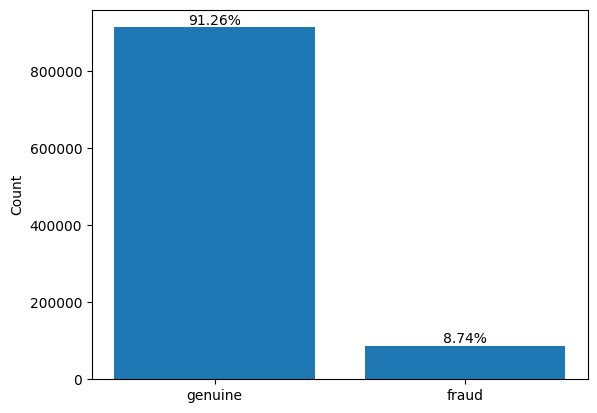

In [5]:
labels = ["genuine", "fraud"]
counts = raw_df["fraud"].value_counts().to_list()
proportion = counts / np.sum(counts) * 100

bar = plt.bar(labels, counts)
plt.ylabel("Count")

# add text inside each bar
for idx, rect in enumerate(bar):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{proportion[idx]:.2f}%', ha='center', va='bottom')

# display the chart
plt.show()

In [13]:
counts

[912597, 87403]

# Knn Classifier

As previously discussed in the preliminary data analysis, the credit card fraud dataset is highly imbalanced, with only 87,403 frauds observations of of 1000000 observations. Since kNN classification is a non-parametric algorithm, applying upsampling techniques like SMOTE would only increase the runtime of making predictions. Therefore, random downsampling will be employed to both increase efficiency and maintain a 50% ratio of each class.

In [38]:
# Stratified sampling on the class
X_train, X_test, y_train, y_test = train_test_split(
    raw_df.drop("fraud", axis = 1), 
    raw_df["fraud"], 
    test_size=0.80, 
    random_state=123, 
    stratify=raw_df["fraud"]
)
X_train.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
679281,14.228889,1.639855,4.104065,1.0,1.0,0.0,0.0
414524,19.058904,1.409901,3.408421,1.0,1.0,0.0,1.0
778192,2.646068,1.984384,2.859258,1.0,1.0,0.0,1.0
495061,12.625542,0.060618,1.035773,1.0,1.0,0.0,0.0
158233,14.586982,1.332998,2.657770,1.0,0.0,0.0,0.0


In [42]:
class_count(y_train)

,Class,Count
0,Non-Fraud,182519
1,Fraud,17481


Table X: A count of each class type in X_train

In [43]:
# Separate majority and minority classes
majority_class = X_train[y_train == 0]
minority_class = X_train[y_train == 1]

# Sample the majority class to balance the data
n_samples = len(minority_class)
majority_sampled = majority_class.sample(n=n_samples, replace=False, random_state=123)

# Concatenate the minority and sampled majority class dataframes
X_train_balanced = pd.concat([minority_class, majority_sampled], axis=0)
y_train_balanced = pd.Series([1] * n_samples + [0] * n_samples)
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced)

In [44]:
class_count(y_train_balanced)

,Class,Count
0,Non-Fraud,17481
1,Fraud,17481


Table X: The newly balanced training data

Knn is an algorithm that relies on the distances between the observations to classify new instances. If the scales of the different features in the dataset are not normalized, then the features with larger scales will dominate the distance metric which make it difficult for features with smaller scales to contribute meaningfully to the classification. In the case of credit card fraud, `distance_from_home` has a range of 10632.72 unit which is far large than the range our binary attributes. For this reason, the data will be scaled with `StandardScaler` before any other steps.

The process of selecting predictors and tuning hyperparameters are closely related. It may be the case that a certain number of predictors would work well for a certain k value but poorly for other k values, so in order to find the optimal number of predictors we have to test it with several k values. By utilizing a 5-fold cross-validation and testing 35 combinations of predictors and k values, we can concurrently try different pairs of k value and predictors. In regards to predictor selection, we will be using `SelectKBest` to perform univariate feature selection using the ANOVA statistical test. Each potential predictor will be analyzed with our class to determine if there were a statistically signficiant relationship between the two.

In [80]:
# Define the hyperparameters to tune
param_grid = {
    'selectkbest__k': [1, 2, 3, 4, 5, 6, 7],
    'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 15]
}

clf = make_pipeline(
    StandardScaler(),
    SelectKBest(score_func=f_classif),
    KNeighborsClassifier())

# Perform grid search with 5-fold cross validation
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_balanced, y_train_balanced)

# Print the best hyperparameters and corresponding score
results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score']]
results = pd.concat([results.drop('params', axis=1), 
                results['params'].apply(lambda x: pd.Series(x))], axis=1)
results.columns = ["Mean Test Score", "# of Neighbors", "# of Predictors"]

In [82]:
results.sort_values(by='Mean Test Score', ascending = False).head(10)

,Mean Test Score,# of Neighbors,# of Predictors
6,0.994480,3,7
13,0.993707,5,7
20,0.992964,7,7
27,0.992792,9,7
34,0.991705,15,7
5,0.990790,3,6
12,0.989932,5,6
19,0.989074,7,6
26,0.988845,9,6
33,0.987529,15,6


Table X: The 10 hyperparamter combinations that give the most efficient validation score

# Todo replace Table X with the table number of the above table
Table X notably shows that the top 5 accurate pair of hyperparameters use all 7 predictors from our original dataset. That means that each of the predictors are an important component to correctly classifying the label of any incoming transactions. We will now look closer into different k values over a larger range that what is shown in Table X by looking at odd values between [3, 69]

In [93]:
param_grid = {
    'kneighborsclassifier__n_neighbors': [2*i + 1 for i in range(1, 35)]
}

clf = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier())

# Perform grid search with 5-fold cross validation
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid_search.fit(X_train_balanced, y_train_balanced)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier())]),
             param_grid={'kneighborsclassifier__n_neighbors': [3, 5, 7, 9, 11,
                                                               13, 15, 17, 19,
                                                               21, 23, 25, 27,
                                                               29, 31, 33, 35,
                                                               37, 39, 41, 43,
                                                               45, 47, 49, 51,
                                                               53, 55, 57, 59,
                                                               61, ...]})

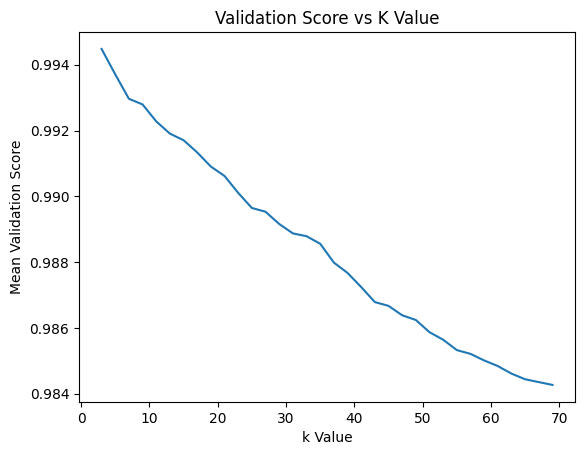

In [99]:
# Create dataframe from hyperparameter
results = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_test_score']]
results = pd.concat([results.drop('params', axis=1), 
                results['params'].apply(lambda x: pd.Series(x))], axis=1)

# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the data as a line chart
ax.plot(results.kneighborsclassifier__n_neighbors, results.mean_test_score)

# Set the title and axis labels
ax.set_title("Validation Score vs K Value")
ax.set_xlabel("k Value")
ax.set_ylabel("Mean Validation Score")

# Show the chart
plt.show()

As shown from the above graph, most k values are very accurate in determining the transaction label only differing by a percent. We've decided to use a k value of 3 because it yielded the most accurate score in combination with out predictor selection as shown in table X (same value as the todo from above).

The final knn classifier can know be trained so we can test it on our testing data.

In [108]:
knn_clf = make_pipeline(
    StandardScaler(),
    KNeighborsClassifier(n_neighbors = 3))

knn_clf.fit(X_train_balanced, y_train_balanced)

knn_pred = knn_clf.predict(X_test)
display(f1_score(y_test, knn_clf.predict(X_test)))

0.9584970462975683

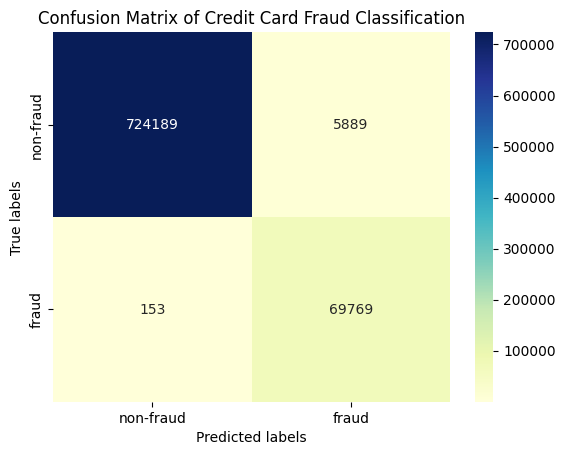

In [115]:
cm = confusion_matrix(y_test, knn_pred)

# Create a heatmap from the confusion matrix using seaborn
class_names = ['non-fraud', 'fraud']
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=class_names, yticklabels=class_names)

# Set the axis labels and title
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix of Credit Card Fraud Classification")

# Show the plot
plt.show()

# Todo include analysis of results, talk about accuracy, f1 score, if this is good enough, possible reasons from high fraud misclassifications.